In [1]:
import matplotlib.pyplot as plt

from scipy.integrate import odeint
import numpy as np
import math

from gym_brt.quanser import QubeHardware, QubeSimulator
from gym_brt.quanser.qube_interfaces import forward_model_ode

from gym_brt.control import (
    zero_policy,
    constant_policy,
    random_policy,
    square_wave_policy,
    pd_control_policy,
    flip_and_hold_policy,
    square_wave_flip_and_hold_policy,
)


# Helper functions

In [2]:
# Run on the hardware
def run_qube(begin_up, policy, nsteps, frequency, integration_steps):
    with QubeHardware(frequency=frequency, max_voltage=3.0) as qube:
        
        if begin_up is True:
            s = qube.reset_up()
        elif begin_up is False:
            s = qube.reset_down()
        
        # Wait for a little bit before reading the initial state
        for _ in range(15):
            a = random_policy(s)
            s = qube.step(a)

        init_state = s
        a = policy(s, step=0)
        s_hist = [s]
        a_hist = [a]

        for i in range(nsteps):
            s = qube.step(a)
            a = policy(s, step=i+1, frequency=frequency)

            s_hist.append(s) # States
            a_hist.append(a) # Actions

        # Return a 2d array, hist[n,d] gives the nth timestep and the dth dimension
        # Dims are ordered as: ['Theta', 'Alpha', 'Theta dot', 'Alpha dot', 'Action']
        return np.concatenate((np.array(s_hist), np.array(a_hist)), axis=1), init_state

def run_sim(init_state, policy, nsteps, frequency, integration_steps):
    with QubeSimulator(
        forward_model=forward_model_ode,
        frequency=frequency,
        integration_steps=integration_steps,
        max_voltage=3.0,
    ) as qube:
        qube.state = np.asarray(init_state, dtype=np.float64)  # Set the initial state of the simulator

        s = init_state
        a = policy(s, step=0)
        s_hist = [s]
        a_hist = [a]

        for i in range(nsteps):
            s = qube.step(a)
            a = policy(s, step=i+1, frequency=frequency)

            s_hist.append(s) # States
            a_hist.append(a) # Actions

        # Return a 2d array, hist[n,d] gives the nth timestep and the dth dimension
        # Dims are ordered as: ['Theta', 'Alpha', 'Theta dot', 'Alpha dot', 'Action']
        return np.concatenate((np.array(s_hist), np.array(a_hist)), axis=1)

In [3]:
def plot_results(hists, labels, colors=None, normalize=None):
    state_dims = ['Theta', 'Alpha', 'Theta dot', 'Alpha dot', 'Action']
    
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True)
    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        
        # Normalize to be between 0 and 2pi
        if normalize is not None:
            if state_dims[i].lower() in normalize:
                for hist in hists:
                    hist[:,i] %= 2 * np.pi

        # Plot with specific colors
        if colors is not None:
            for hist, label, color in zip(hists, labels, colors):
                ax.plot(hist[:,i], label=label, color=color)

        # Default colors
        else:
            for hist, label in zip(hists, labels):
                ax.plot(hist[:,i], label=label)
        ax.set_ylabel(state_dims[i])
        ax.legend()
    plt.show()

# Run experiments

In [4]:
# Constants between experiments
frequency = 250 # in Hz
run_time = 5 # in seconds
nsteps = int(run_time * frequency)
i_steps = 1

In [5]:
plt.rcParams["figure.figsize"] = (20,20) # make graphs BIG

# Natural responses

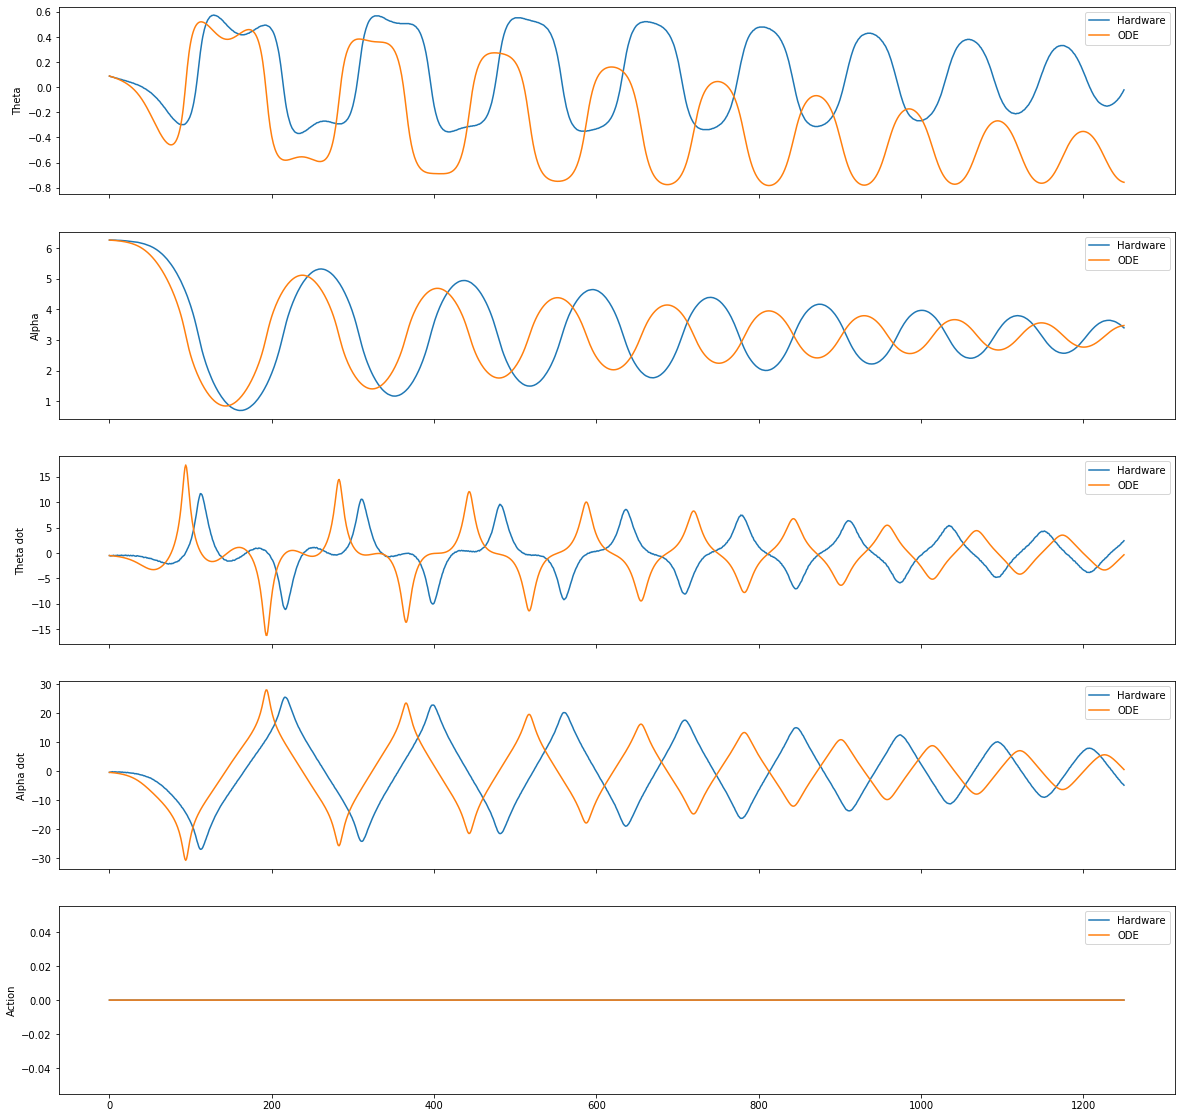

In [6]:
# Natural response when starting at α = 0 + noise (upright/inverted)
hist_qube, init_state = run_qube(True, zero_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, zero_policy, nsteps, frequency, i_steps)

# plot_results(hists=[hist_qube], labels=['Hardware'], colors=None)
plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], normalize=['alpha'])

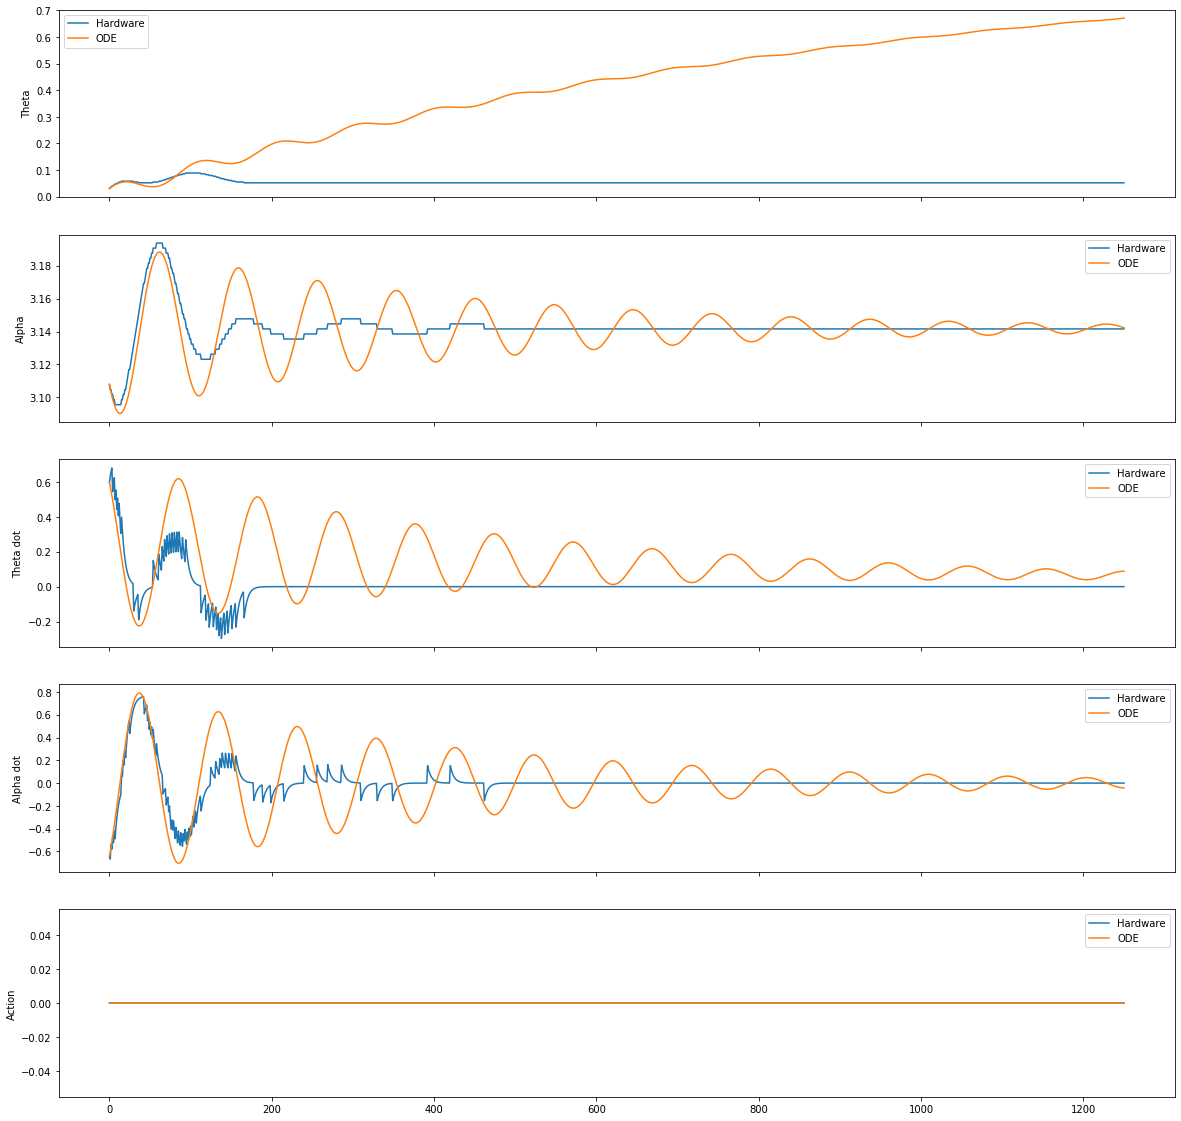

In [9]:
# Natural response when starting at α = π + noise (downwards/at rest)
hist_qube, init_state = run_qube(False, zero_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, zero_policy, nsteps, frequency, i_steps)

plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], normalize=['alpha'])

# Forced response

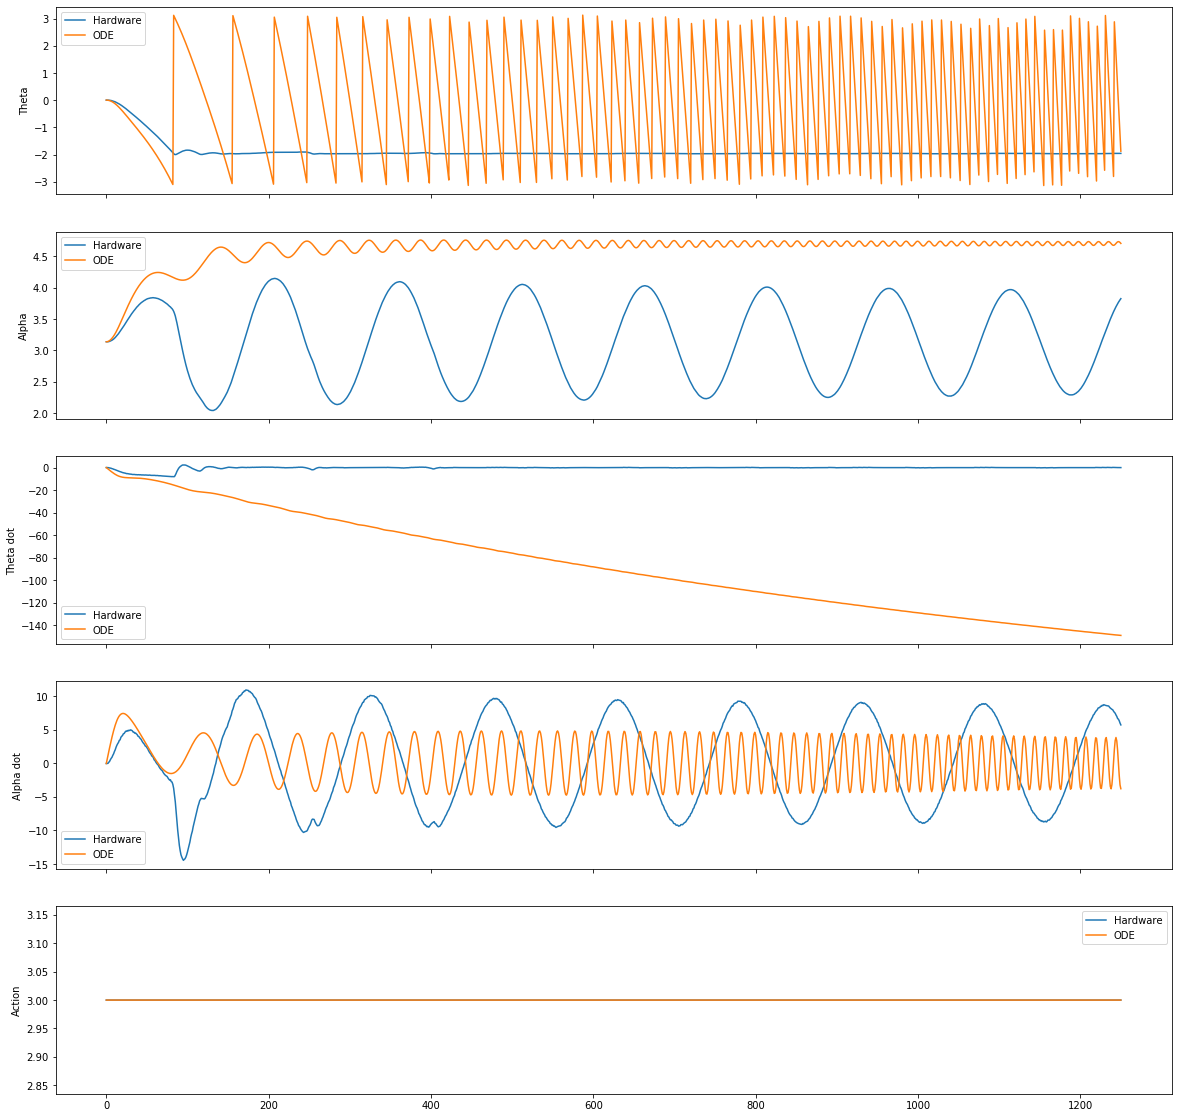

In [10]:
# Focred responce when starting at α = π + noise (downwards/at rest), and using a constant policy
hist_qube, init_state = run_qube(False, constant_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, constant_policy, nsteps, frequency, i_steps)

plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], normalize=['alpha'])

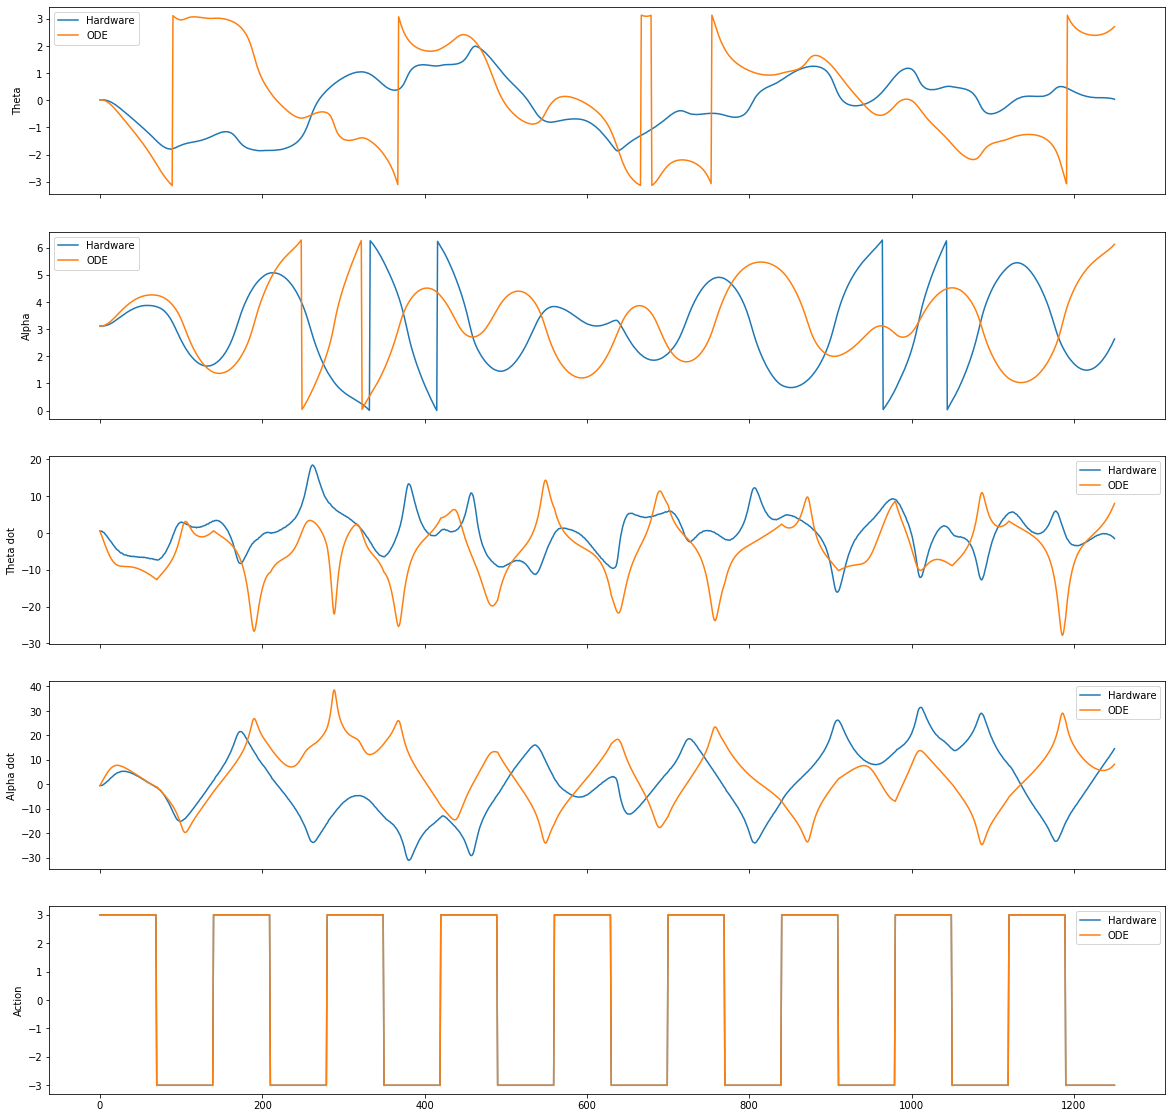

In [11]:
# Forced response when starting at α = π + noise (downwards/at rest), and using a policy that 
# switches direction every 85 steps
hist_qube, init_state = run_qube(False, square_wave_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, square_wave_policy, nsteps, frequency, i_steps)

plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], normalize=['alpha'])

# PD controller (starting inverted)

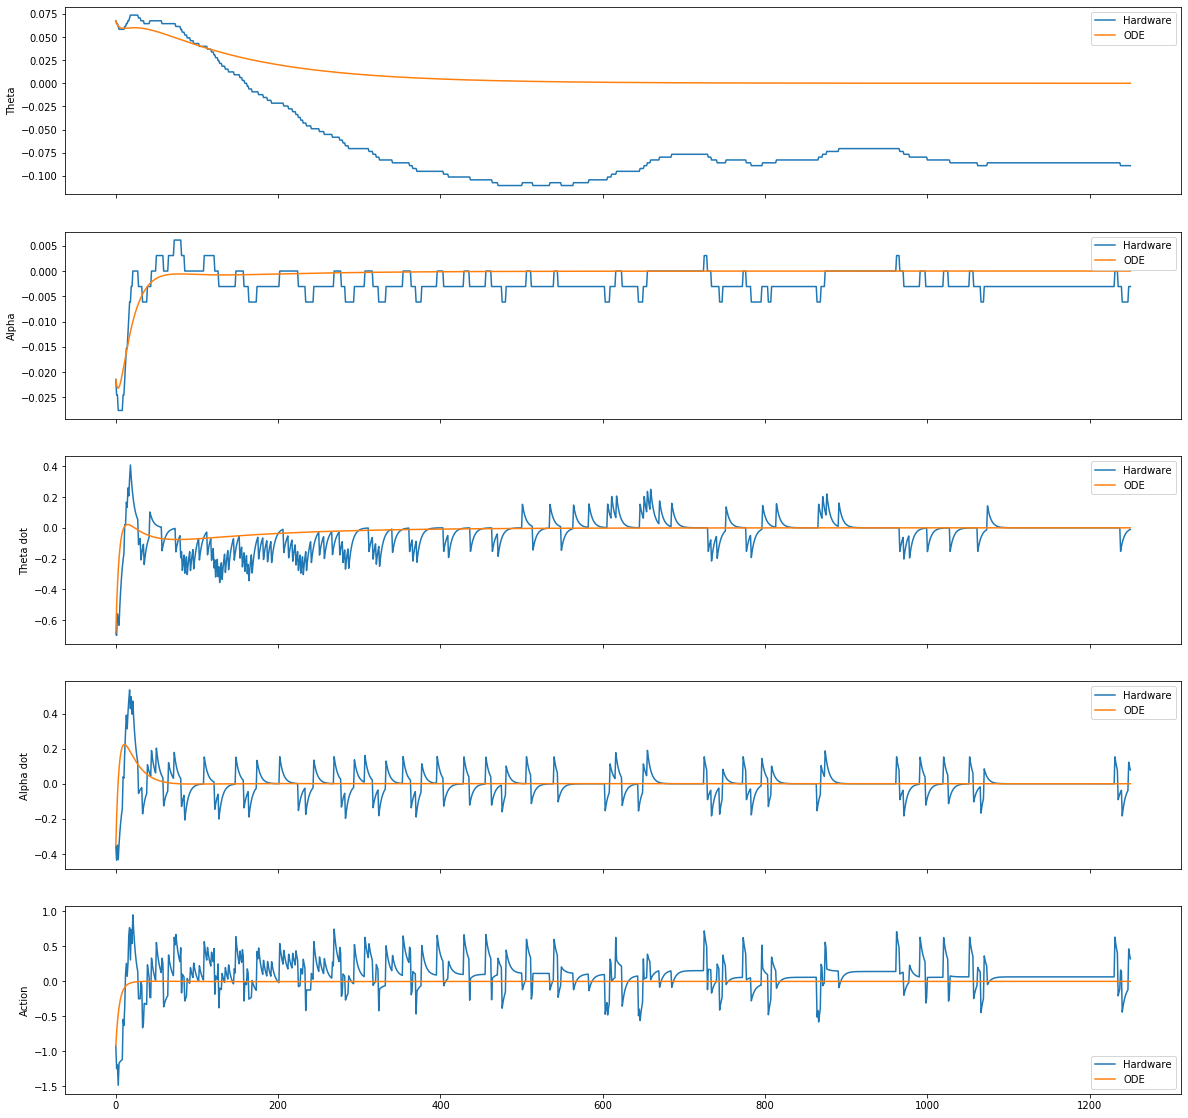

In [12]:
# PD controller to hold when starting at α = 0 + noise (inverted)
hist_qube, init_state = run_qube(True, pd_control_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, pd_control_policy, nsteps, frequency, i_steps)

plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], colors=None)


# Energy + PD controller to flip and hold (starting down)

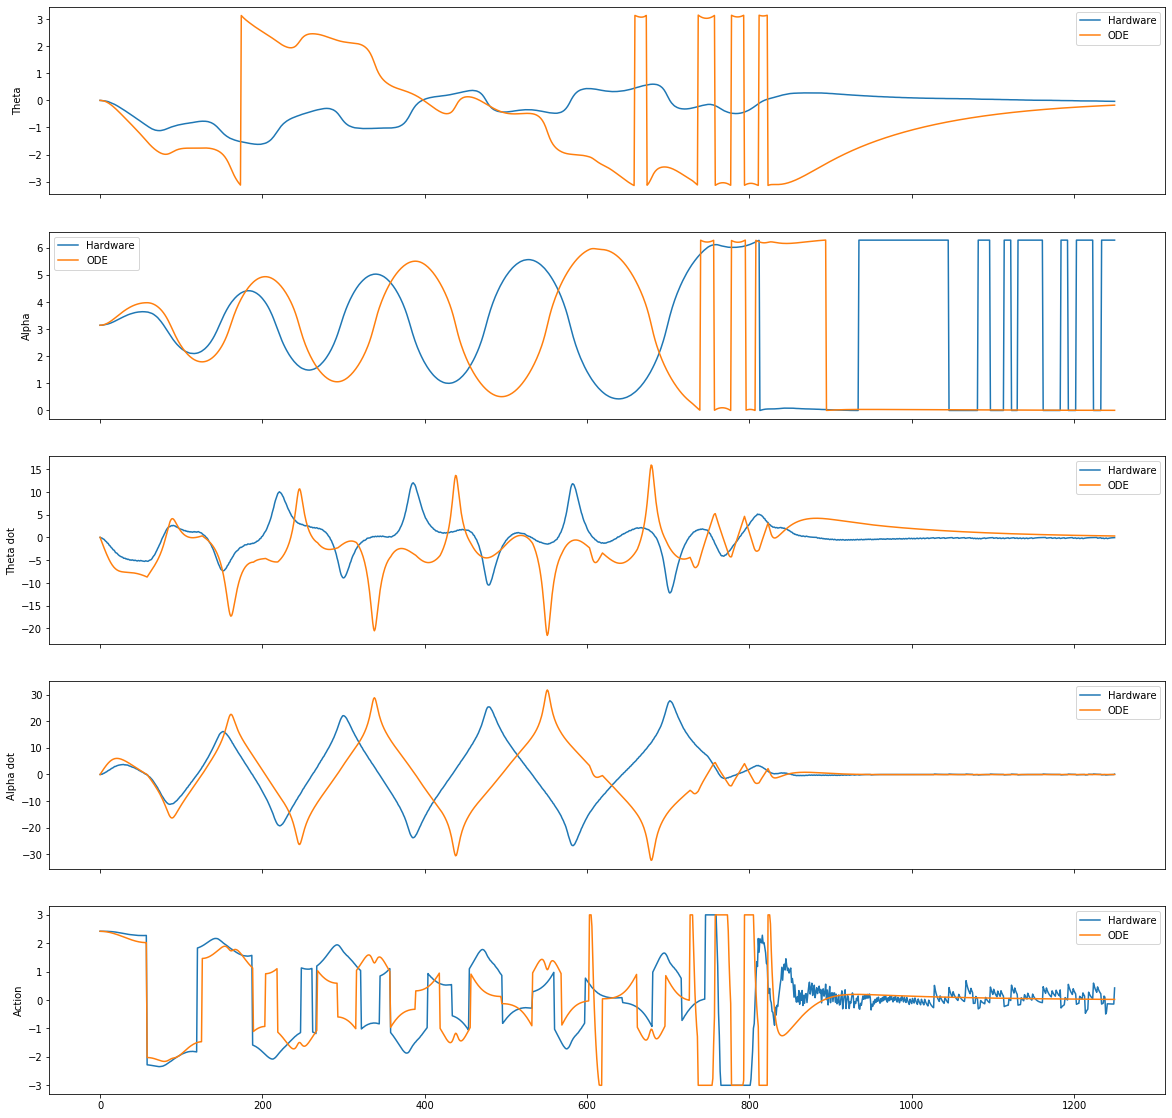

In [13]:
# Energy + PD controller to hold when starting at α = π + noise (inverted)
hist_qube, init_state = run_qube(False, flip_and_hold_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, flip_and_hold_policy, nsteps, frequency, i_steps)

plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], normalize=['alpha'])

# Square wave + PD controller to flip and hold (starting down)
This often seems to work on the Qube, so it should work on the sim too

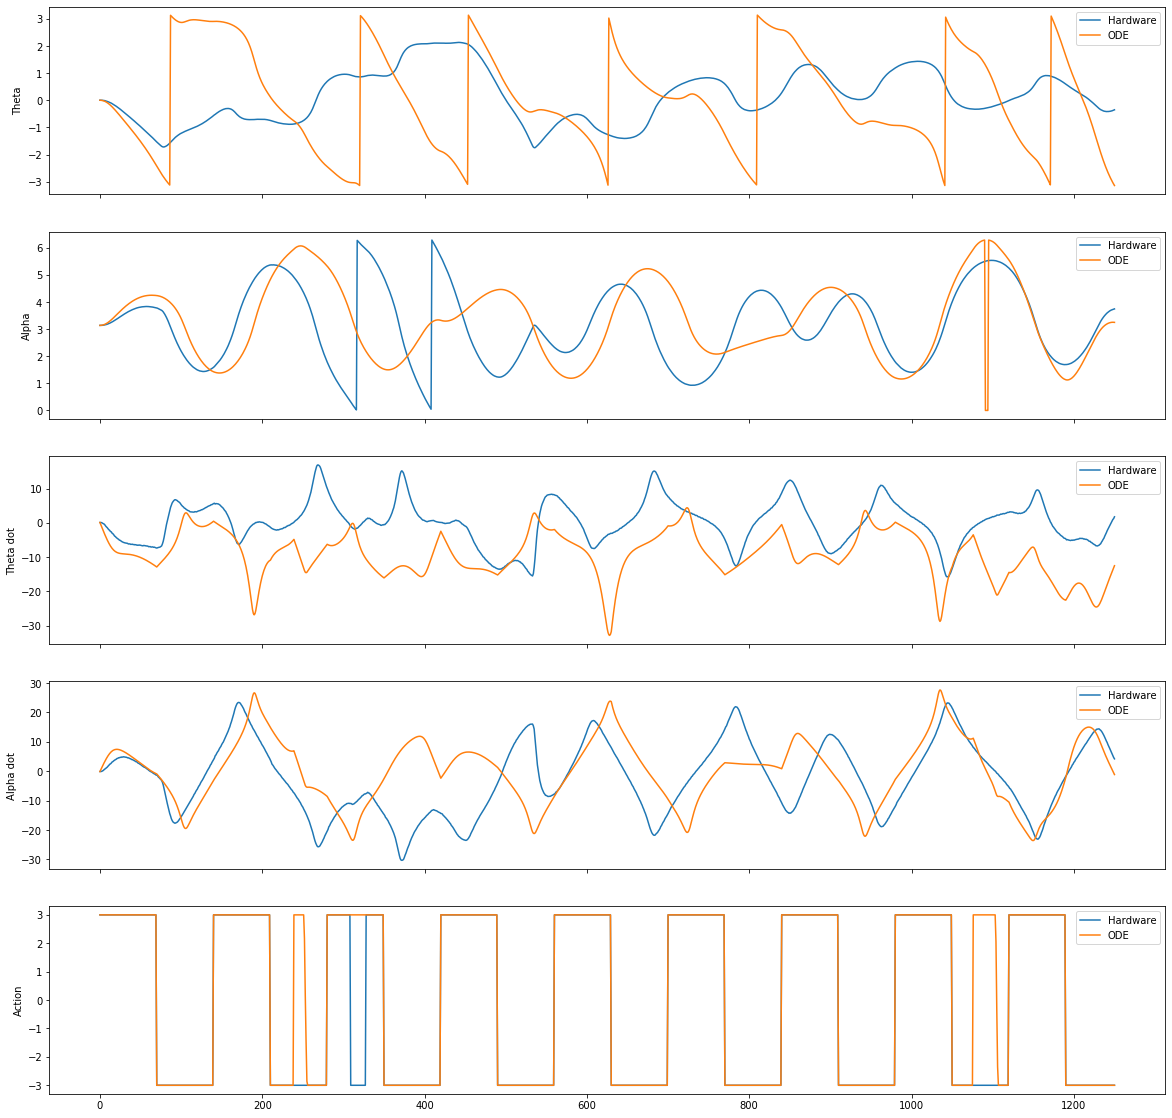

In [14]:
# Energy + PD controller to hold when starting at α = π + noise (inverted)
hist_qube, init_state = run_qube(False, square_wave_flip_and_hold_policy, nsteps, frequency, i_steps)
hist_ode = run_sim(init_state, square_wave_flip_and_hold_policy, nsteps, frequency, i_steps)

plot_results(hists=[hist_qube, hist_ode], labels=['Hardware', 'ODE'], normalize=['alpha'])